# Problem Statement

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

We are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

## Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds
 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import haversine as hs
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\jason\Documents\Jerry\Studies\Jerry DSc\IS\EDA-ML-Final-Project\EDA+ML-Final Project\nyc_taxi_trip_duration.csv")

### Explore

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


In [5]:
df.shape

(729322, 11)

In [6]:
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)
df.dropoff_datetime=pd.to_datetime(df.dropoff_datetime)
df['pu_hour'] = df.pickup_datetime.dt.hour
df['yday'] = df.pickup_datetime.dt.dayofyear
df['wday'] = df.pickup_datetime.dt.dayofweek

In [7]:
day =1
df_day=df[((df.pickup_datetime<'2016-02-'+str(day+1))&
           (df.pickup_datetime>='2016-02-'+str(day)))]

In [8]:
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [9]:
df['distance'] = haversine_np(df.pickup_longitude, df.pickup_latitude,
                                           df.dropoff_longitude, df.dropoff_latitude)

In [10]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,distance
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,16,60,0,1.198320
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,23,71,4,4.126519
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,17,52,6,7.246201
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,9,5,1,2.359615
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,6,48,2,4.325816


In [11]:
df = df.drop(['id','pickup_latitude','pickup_longitude','dropoff_longitude','dropoff_latitude'],axis=1)

In [12]:
df['store_and_fwd_flag'] = (
    df['store_and_fwd_flag'].replace(['N'],'0')
    .replace(['Y'],'1')
)

In [13]:
x = df.drop('trip_duration', axis=1)
y = df['trip_duration']

In [14]:
df.describe()

,vendor_id,passenger_count,trip_duration,pu_hour,yday,wday,distance
count,729322.000000,729322.000000,7.293220e+05,729322.000000,729322.000000,729322.000000,729322.000000
mean,1.535403,1.662055,9.522291e+02,13.611698,91.882577,3.049081,3.438978
std,0.498745,1.312446,3.864626e+03,6.402853,51.555655,1.954470,4.350399
min,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,3.970000e+02,9.000000,48.000000,1.000000,1.231921
50%,2.000000,1.000000,6.630000e+02,14.000000,92.000000,3.000000,2.094356
75%,2.000000,2.000000,1.075000e+03,19.000000,136.000000,5.000000,3.874047
max,2.000000,9.000000,1.939736e+06,23.000000,182.000000,6.000000,1240.129578


In [15]:
df.corr()

,vendor_id,passenger_count,trip_duration,pu_hour,yday,wday,distance
vendor_id,1.000000,0.286463,0.027752,0.009772,-0.005227,0.000787,0.006510
passenger_count,0.286463,1.000000,0.013022,0.009851,-0.001182,0.025758,0.009175
trip_duration,0.027752,0.013022,1.000000,0.002979,0.009418,-0.002302,0.125772
pu_hour,0.009772,0.009851,0.002979,1.000000,-0.003549,-0.082079,-0.016269
yday,-0.005227,-0.001182,0.009418,-0.003549,1.000000,-0.012497,0.017201
wday,0.000787,0.025758,-0.002302,-0.082079,-0.012497,1.000000,0.007786
distance,0.006510,0.009175,0.125772,-0.016269,0.017201,0.007786,1.000000


In [16]:
df['trip_duration'].describe()/3600

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

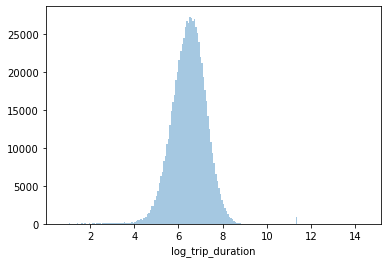

In [17]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

### Visualisations

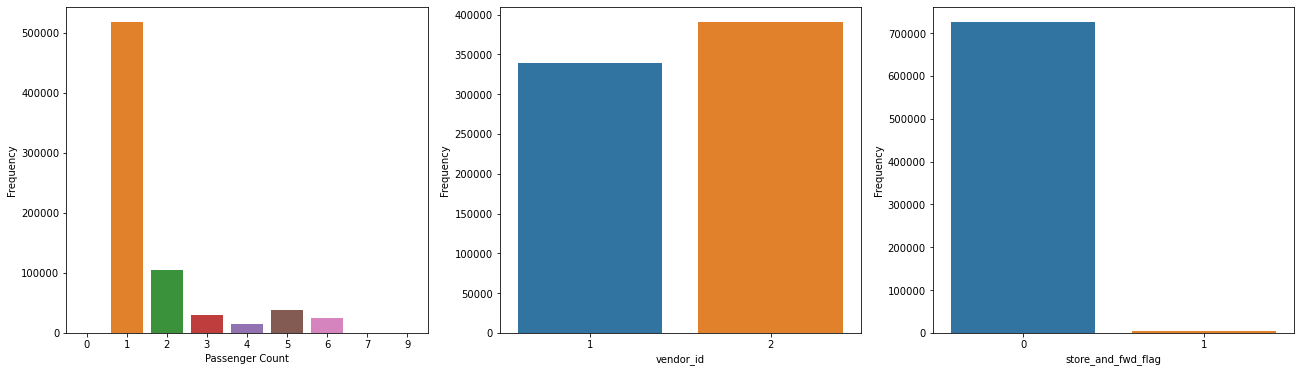

In [18]:
plt.figure(figsize=(22, 6))

plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')

plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency');

We can drop store_and_fwd_flag since we cannot draw any actionable insight with this data.

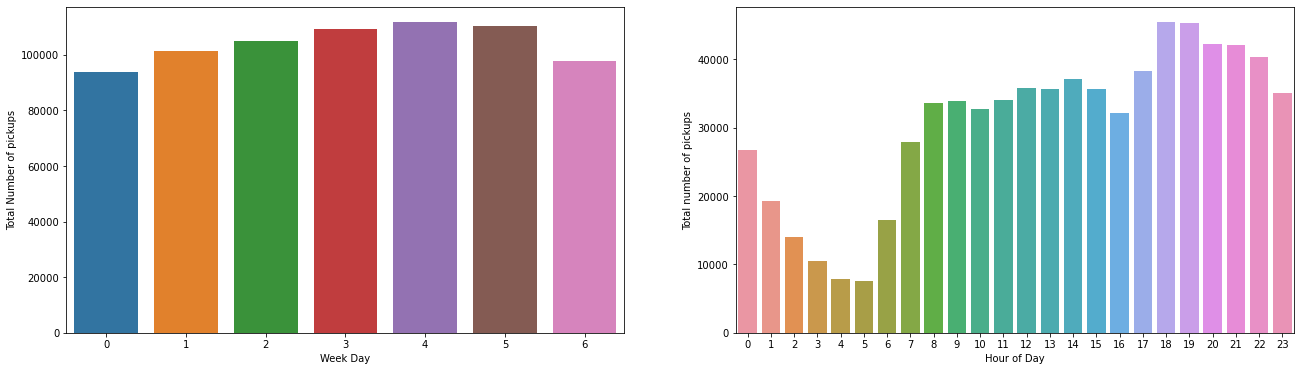

In [19]:
plt.figure(figsize=(22, 6))

plt.subplot(121)
sns.countplot(df['wday'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')

plt.subplot(122)
sns.countplot(df['pu_hour'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups');

Peak pickup day is Thursday and peak hours are in the evening and least pickups occur early morning.

<AxesSubplot:xlabel='pu_hour', ylabel='trip_duration'>

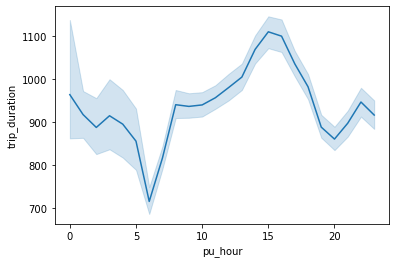

In [20]:
sns.lineplot(x="pu_hour",y='trip_duration',data=df)

## Split

In [21]:
features = ["pu_hour","yday","wday","distance","vendor_id","passenger_count"]
X = df[features]

In [22]:
target = "trip_duration"
y = df[target]

## Build Model

### Baseline

In [23]:
y_mean = y.mean()
y_pred_baseline = [y_mean] * len(y)
print("Mean time:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y, y_pred_baseline))

Mean time: 952.23
Baseline MAE: 618.7709390780225


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X,y)

LinearRegression()

### Linear Regression

In [26]:
y_prediction =  LR.predict(X_test)

In [27]:
print(LR.intercept_)

171.48559089511411


In [28]:
print(LR.coef_)

[  2.72186494   0.55297188  -5.84353018 111.51527299 198.53723994
  13.45927164]


In [29]:
print('Pred Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_prediction)))

Pred Mean Absolute Error: 456.5261661228884
Mean Squared Error: 9704669.602585351
Root Mean Squared Error: 3115.2318697948235


## K-Nearest neighbours’

In [30]:
features = ["pu_hour","yday","wday","distance","vendor_id","passenger_count"]
x = df[features]
target = "trip_duration"
y = df[target]

In [31]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x = pd.DataFrame(x_scaled)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42)

In [33]:
clf = KNN(n_neighbors = 2)
clf.fit(X_train, y_train)
test_predict = clf.predict(X_test)
print('Pred Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, test_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_predict)))

Pred Mean Absolute Error: 533.0860084132704
Mean Squared Error: 34406118.602736235
Root Mean Squared Error: 5865.672902808017


In [34]:
def Elbow(K):
    test_mse = []
    
    for i in K:

        reg = KNN(n_neighbors = i)
        reg.fit(X_train, y_train)
        
        tmp = reg.predict(X_test)
        tmp = mse(tmp,y_test)
        test_mse.append(tmp)
    
    return test_mse

In [35]:
k = range(1, 8)

In [36]:
test = Elbow(k)

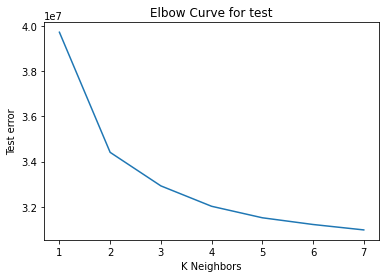

In [37]:
plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('Test error')
plt.title('Elbow Curve for test');

## Decision Tree

In [38]:
features = ["pu_hour","yday","wday","distance","vendor_id","passenger_count"]
X = df[features]
y = df["trip_duration"]

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42)

In [40]:
dtc = DecisionTreeRegressor()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)
print('Pred Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_dtc))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_dtc))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_dtc)))

Pred Mean Absolute Error: 595.4760819608294
Mean Squared Error: 42142048.31862794
Root Mean Squared Error: 6491.690713414183


In [41]:
def rmse_fun(predicted, actual):
    return np.sqrt(np.mean(np.square(predicted - actual)))
rmse = make_scorer(rmse_fun, greater_is_better=False)

In [42]:
rf_model = RandomForestRegressor(n_estimators=25, min_samples_leaf=25, min_samples_split=25)
tree_model = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)
knn_model = KNN(n_neighbors=25, weights='distance')
ridge_model = Ridge(alpha=75.0)
lasso_model = Lasso(alpha=0.75)

<AxesSubplot:title={'center':'The CV scores of Models'}, xlabel='Model'>

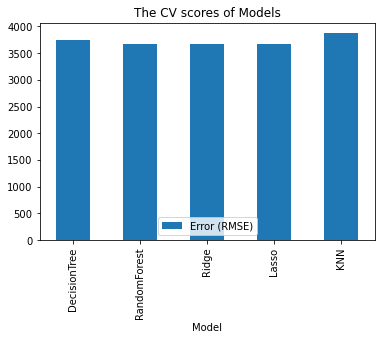

In [43]:
models = [
     ('DecisionTree', tree_model),
     ('RandomForest', rf_model),
     ('Ridge', ridge_model),
     ('Lasso', lasso_model),
     ('KNN', knn_model),

]

scores = [
    -1.0 * cross_val_score(model, X.values, y.values, scoring=rmse).mean()
    for _,model in models
]

dataz = pd.DataFrame({ 'Model': [name for name, _ in models], 'Error (RMSE)': scores })
dataz.plot(x='Model', kind='bar',title='The CV scores of Models')

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
9. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
10. All models beat the baseline and Linear Regressor shows least error. Distance and Vendor ID have high coefficients in this model.